# Illustrating energy dependencies of the model

This notebook demonstrates the contribution of electrons at different energies to the overall Crab Nebula SED using the const. B-field model and its updated 3D representation of Meyer et al. (2010). It also shows how the predicted extension of the nebula can be retrieved as a function of photon energy. 

In [90]:
import sys
sys.path.append("/Users/manuelmeyer/Python/crabmeyerpy/")
sys.path.append("/Users/manuelmeyer/Python/fast_interp/")

In [91]:
from crabmeyerpy.ssc import kpc2cm, m_e_eV, arcmin2rad, eV2erg, eV2Hz, CrabSSC
from crabmeyerpy.ssc_3d import CrabSSC3D
from crabmeyerpy.electrondensity import nel_crab, nel_crab_extension
from crabmeyerpy.photonfields import black_body
from crabmeyerpy.data import CrabData
from scipy.integrate import simps, romb
from nonthermal.sync import Esync_peak, gamma_sync_peak
import matplotlib.pyplot as plt
import numpy as np
import logging
import copy
import astropy.constants as c
import astropy.units as u
import time

In [92]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 3D model

Initialize the 3D model

In [93]:
d = 2.  # distance to Crab in kpc

In [94]:
# config to match 1D case
config = {
    # electron spectrum parameters
    "Nradio": np.exp(-9.5) * 1.3, # these are just some scalings
    "gradio_min": np.exp(3.1),
    "gradio_max": np.exp(12.1),
    "Sradio": -1.60,
    "Nwind": np.exp(-48.) * 2, # these are just some scalings
    "gmin": np.exp(3.1),
    "gmax": np.exp(30.),
    "gwind_min": np.exp(13.1),
    "gwind_max": np.exp(22.6),
    "gwind_b": 1. / np.exp(19.5),
    "Swind": -2.85,
    "Sbreak": -0.6, 
    "sup_wind": 2.8,
    # spatial parameters, this is new
    "gamma_br_const": 34e9 / m_e_eV, # below this gamma value, the nebula has constant size, in Hillas et al: 34. GeV
    "radio_size_cm": np.tan(1.35 * arcmin2rad) * d * kpc2cm,  # constant size of Gaussian below gamma_br_constant in arcmin 
    "index": -0.17,  # power-law index of energy dependency
    "amplitude": np.tan(1.2 * arcmin2rad) * d  * kpc2cm,  # amplitude for PL spatial dependence
    "offset": np.tan(0.15 * arcmin2rad) * d * kpc2cm,  # offset for high energies
    "dust_T": 97.6,
    "dust_norm": 1.0e-11  / (0.001 * kpc2cm)**3 / 4. / np.pi,  # for new dust function
    "dust_extension": 1.3,  # extension of nebula in FIR from dust
    "ic_sync": True, 
    "ic_dust": True,
    "ic_cmb": True,
    "B": 124.e-6
}

In [95]:
print("Break energy of wind spectrum {0:e}eV".format(1. / config['gwind_b'] * m_e_eV))

Break energy of wind spectrum 1.503704e+14eV


In [96]:
# maximum radius of nebula
# This number should probably be updated to newer values
# it comes from Atoyan & Aharonian 1996
r0_pc = 1.8

In [97]:
# the assumed electron spectrum
def n_el_spec(gamma, r, **params):
    return nel_crab(gamma, **params) * nel_crab_extension(r, gamma, **params)

# the assumed radial dependence of the magnetic field
def const_B(r, **params):
    result = np.full(r.shape, params['B'])
    return result

Initialize the model

In [98]:
ssc = CrabSSC3D(copy.deepcopy(config), n_el_spec, const_B, d_kpc=d, r0_pc=r0_pc, log_level="DEBUG", 
                ic_sync=True, ic_cmb=True, ic_dust=True)

Set the dust parameters

In [99]:
ssc.parameters['dust_extension'] = 1.3
ssc.dust_radial_dependence = 'gauss'
ssc.parameters['dust_norm'] = 1.0e-11  / (0.001 * kpc2cm)**3 / 4. / np.pi

print("Dust extension: {0:.2f} arcmin".format(ssc.parameters['dust_extension']))

Dust extension: 1.30 arcmin


## Calculate the full SED

Do one pass of the full SED calculation.

In [100]:
t0 = time.time()
# define r and nu arrays
r = np.linspace(0., ssc.r0, 10)
nu_all = np.logspace(7., 31., 300)

nu_sync = nu_all[nu_all <=1e25]
nu_ic = nu_all[nu_all >= 1e20]

# Calculate and interpolate the synchrotron spectrum
ssc.use_fast_interp = True  # use a 2D interpolation routine using numba
ssc.interp_sync_init(r_min=r.min(), r_max=r.max())

# Calculate the intensities along the line of sight
I_nu_sync, theta_arcmin, _ = ssc.intensity2(nu_sync, theta=20)
I_nu_dust, _, _ = ssc.intensity2(nu_sync, theta=20, which='dust')
# Calculate the fluxes
f_nu_sync = ssc.flux(nu_sync, theta_edges=[theta_arcmin[0], theta_arcmin[-1]],
                     which='sync',
                     integration_mode='romb',
                     theta_steps=33)

f_nu_dust = ssc.flux(nu_sync, theta_edges=[theta_arcmin[0], theta_arcmin[-1]],
                     which='dust',
                     integration_mode='romb',
                     theta_steps=33)

# Calculate the IC emissivity
r_ic_egdes = np.linspace(0., ssc.r0, 33)
r_ic = 0.5 * (r_ic_egdes[1:] + r_ic_egdes[:-1])

g_steps = 129  # steps for integration over gamma
e_steps = 129  # steps for integration over energy of seed photon field
r1_steps = 65   # steps for integration over radius, see Atoyan & Aharonian (1996) Eq. 15

ssc.integration_mode = 'numba_piecewise'  # fastest option
ssc.use_fast_interp = True  # fastest mode of interpolation

j_nu_ic = ssc.j_ic(nu_ic, r_ic,
                   g_steps=g_steps,
                   e_steps=e_steps,
                   r1_steps=r1_steps)

# calculate the intensity along the line of sight
I_nu_ic, theta_arcmin_ic, _ = ssc.intensity2(nu_ic, theta=20, which='ic')

# calculate the IC flux
f_nu_ic = ssc.flux(nu_ic, theta_edges=[theta_arcmin[0], theta_arcmin[-1]],
                   which='ic',
                   integration_mode='romb',
                   r_steps=65,
                   theta_steps=65)
t1 = time.time()
logging.info(f"It took {t1-t0:.2f}s")

 ssc_3d.py: 523 --- DEBUG: Black body calculation in grey body function took 0.003s
 ssc_3d.py: 557 --- DEBUG: extension calculation in grey body function took 0.004s
 ssc_3d.py: 523 --- DEBUG: Black body calculation in grey body function took 0.004s
 ssc_3d.py: 557 --- DEBUG: extension calculation in grey body function took 0.007s
 ssc_3d.py: 647 --- DEBUG: (129, 32, 65)
 ssc_3d.py: 648 --- DEBUG: Integrating using numba_piecewise
 ssc_3d.py: 656 --- DEBUG: phot_dens: time for interpolation of Sync: 0.009s, time for integration of SSC component  0.013s,  time for filling arrays 0.005s 
 ssc_3d.py: 523 --- DEBUG: Black body calculation in grey body function took 0.001s
 ssc_3d.py: 557 --- DEBUG: extension calculation in grey body function took 0.001s
 ssc_3d.py: 698 --- DEBUG: time to calculate grey body 0.006s  time for integration of dust component  0.004s
/Users/manuelmeyer/Python/crabmeyerpy/crabmeyerpy/photonfields.py:22: RuntimeWarning: overflow encountered in exp
  result = np.e

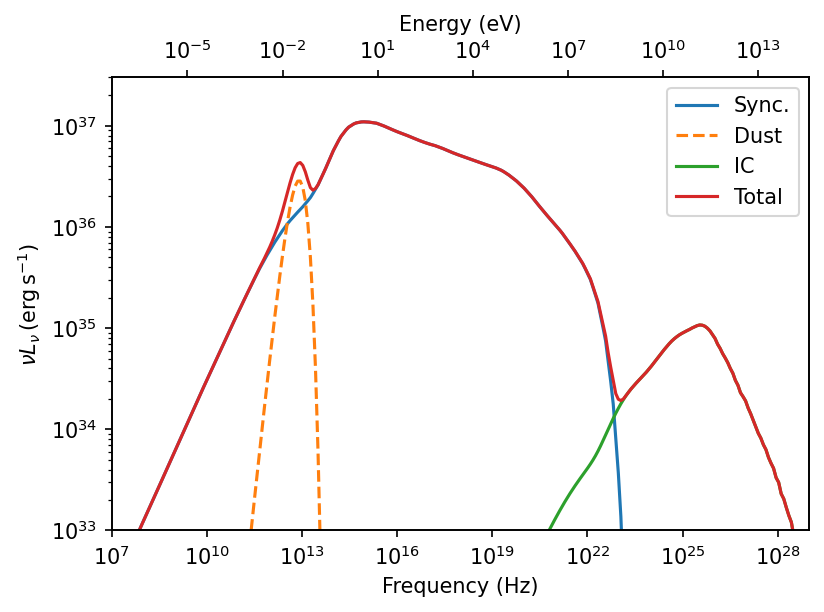

In [101]:
# plotting function to show full sed
def plot_full_sed(luminosity=True, ic=True, sync=True, dust=True, total=True, dpi=150, fig=None, ax=None):
    if fig is None:
        fig = plt.figure(dpi=dpi)

    if ax is None:
        ax = fig.add_subplot(111)
        
    if luminosity:
        const = 4. * np.pi * (d * kpc2cm)**2
    else:
        const = 1.

    if sync:
        ax.loglog(nu_sync, f_nu_sync * nu_sync * const, ls='-', label="Sync.")
    if dust:
        ax.loglog(nu_sync, f_nu_dust * nu_sync * const, ls='--', label="Dust")
    if ic:
        ax.loglog(nu_ic, f_nu_ic * nu_ic * const, ls='-', label="IC")
    if total:
        f_all = np.zeros_like(nu_all)
        m_sync = nu_all <= nu_sync[-1]
        m_ic = nu_all >= nu_ic[0]
        
        f_all[m_sync] += f_nu_sync
        f_all[m_sync] += f_nu_dust
        f_all[m_ic] += f_nu_ic
        
        ax.loglog(nu_all, f_all * nu_all * const, ls='-', label="Total")
    
    if luminosity:
        ax.set_ylim(1e33,3e37)
        ax.set_ylabel(r"$\nu L_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}$)")    

    else:
        ax.set_ylim(1e-13, 1e-7)
        ax.set_ylabel(r"$\nu F_\nu\,(\mathrm{erg}\,\mathrm{cm}^{-2}\,\mathrm{s}^{-1}$)")    
        
    ax.set_xlim(1e7,1e29)
    ax2 = ax.twiny()
    ax2.set_xlim(1e7 * c.h.to("eV s").value, 1e29 * c.h.to("eV s").value)
    ax2.set_xscale("log")
    ax.set_xlabel("Frequency (Hz)")
    ax2.set_xlabel("Energy (eV)")
    return fig, ax

fig, ax = plot_full_sed()
ax.legend()


### SED calculation over limited range of gamma factors

Next, we calculate the SED for a limited range of electron energies. We choose energies that correspond to some peak energies of the synchrotron radiation. In order to find the corresponding gamma factors, we need to invert the equation 
$$E_\mathrm{sync, peak} = \frac{3e}{4\pi m_e hc} B \gamma^2 \sin\theta.$$

We start by defining an array of peak energies:

In [102]:
Epeak_bins = np.concatenate(([1.e-7, 1.e-5], np.logspace(-1,5,7))) * u.eV
Epeak = np.sqrt(Epeak_bins[1:] * Epeak_bins[:-1])
print(Epeak_bins)

[1.e-07 1.e-05 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05] eV


Now we get the corresponding gamma factors. These are obtained from the `nonthermal` python package, available here: https://github.com/me-manu/nonthermal

In [103]:
# get gamma factors that correspond to some peak energies
gamma_peak_bins = gamma_sync_peak(Epeak_bins, B=ssc.parameters["B"])
gamma_peak = np.sqrt(gamma_peak_bins[1:] * gamma_peak_bins[:-1])

Next, we calculate the SEDs for a restricted range of gamma factors. We choose bins of gamma values more or less centered in the peak energies calculated above. Note that we assume this restricted gamma range _both_ for synchrotron and IC emission as if no electrons outside this range were present. For the IC process one could in principle take the synchrotron emission from the restricted range and let it scatter off electrons from the full gamma range. But this is _not_ what we do here. 

In [128]:
# calculate synchrotron flux from gamma factors within these bins
f_nu_sync_bins = np.zeros((Epeak.size, nu_sync.size))
f_nu_ic_bins = np.zeros((Epeak.size, nu_ic.size))
ssc.use_fast_interp = False

gmin = ssc.parameters['gmin']
gmax = ssc.parameters['gmax']

for i, g in enumerate(gamma_peak_bins[:-1]):    
    ssc.interp_sync_init(r_min=r.min(), r_max=r.max(),
                         gmin=g.value, gmax=gamma_peak_bins[i+1].value)
    # Calculate the fluxes
    f_nu_sync_bins[i] = ssc.flux(nu_sync, theta_edges=[theta_arcmin[0], theta_arcmin[-1]],
                         which='sync',
                         integration_mode='romb',
                         theta_steps=33)
    print(ssc._j_sync_interp(np.log(nu_sync), [0.]).max())
    
    ssc.parameters['gmin'] = g.value
    ssc.parameters['gmax'] = gamma_peak_bins[i+1].value
    j_nu_ic_test = ssc.j_ic(nu_ic, r_ic,
                            g_steps=g_steps,
                            e_steps=e_steps,
                            r1_steps=r1_steps)
    
    
    f_nu_ic_bins[i] = ssc.flux(nu_ic, theta_edges=[theta_arcmin[0], theta_arcmin[-1]],
                               which='ic',
                               integration_mode='romb',
                               r_steps=65,
                               theta_steps=65)
    
    #break
    
# restore parameters to full gamma range
ssc.interp_sync_init(r_min=r.min(), r_max=r.max())
ssc.parameters['gmin'] = gmin
ssc.parameters['gmax'] = gmax

-74.34550126363926


 ssc_3d.py: 647 --- DEBUG: (129, 32, 65)
 ssc_3d.py: 648 --- DEBUG: Integrating using numba_piecewise
 ssc_3d.py: 656 --- DEBUG: phot_dens: time for interpolation of Sync: 0.020s, time for integration of SSC component  0.007s,  time for filling arrays 0.004s 
/Users/manuelmeyer/Python/crabmeyerpy/crabmeyerpy/photonfields.py:22: RuntimeWarning: overflow encountered in exp
  result = np.exp(kx) - 1.
 ssc_3d.py: 523 --- DEBUG: Black body calculation in grey body function took 0.002s
 ssc_3d.py: 557 --- DEBUG: extension calculation in grey body function took 0.001s
 ssc_3d.py: 698 --- DEBUG: time to calculate grey body 0.007s  time for integration of dust component  0.005s
 ssc_3d.py: 818 --- DEBUG: kernel shape for integration over photon dens energy: (138, 129, 129, 32)
 ssc_3d.py: 826 --- DEBUG: kernel shape for integration over gamma factor: (138, 129, 32)
 ssc_3d.py: 843 --- DEBUG: integration over photon dens and gamma took 4.360s


-75.64208989773593


 ssc_3d.py: 647 --- DEBUG: (129, 32, 65)
 ssc_3d.py: 648 --- DEBUG: Integrating using numba_piecewise
 ssc_3d.py: 656 --- DEBUG: phot_dens: time for interpolation of Sync: 0.018s, time for integration of SSC component  0.006s,  time for filling arrays 0.002s 
 ssc_3d.py: 523 --- DEBUG: Black body calculation in grey body function took 0.002s
 ssc_3d.py: 557 --- DEBUG: extension calculation in grey body function took 0.001s
 ssc_3d.py: 698 --- DEBUG: time to calculate grey body 0.006s  time for integration of dust component  0.004s
 ssc_3d.py: 818 --- DEBUG: kernel shape for integration over photon dens energy: (138, 129, 129, 32)
 ssc_3d.py: 826 --- DEBUG: kernel shape for integration over gamma factor: (138, 129, 32)
 ssc_3d.py: 843 --- DEBUG: integration over photon dens and gamma took 4.505s


-79.18764810535932


 ssc_3d.py: 647 --- DEBUG: (129, 32, 65)
 ssc_3d.py: 648 --- DEBUG: Integrating using numba_piecewise
 ssc_3d.py: 656 --- DEBUG: phot_dens: time for interpolation of Sync: 0.017s, time for integration of SSC component  0.006s,  time for filling arrays 0.002s 
 ssc_3d.py: 523 --- DEBUG: Black body calculation in grey body function took 0.002s
 ssc_3d.py: 557 --- DEBUG: extension calculation in grey body function took 0.001s
 ssc_3d.py: 698 --- DEBUG: time to calculate grey body 0.006s  time for integration of dust component  0.004s
 ssc_3d.py: 818 --- DEBUG: kernel shape for integration over photon dens energy: (138, 129, 129, 32)
 ssc_3d.py: 826 --- DEBUG: kernel shape for integration over gamma factor: (138, 129, 32)
 ssc_3d.py: 843 --- DEBUG: integration over photon dens and gamma took 5.530s


-79.57225894698821


 ssc_3d.py: 647 --- DEBUG: (129, 32, 65)
 ssc_3d.py: 648 --- DEBUG: Integrating using numba_piecewise
 ssc_3d.py: 656 --- DEBUG: phot_dens: time for interpolation of Sync: 0.016s, time for integration of SSC component  0.006s,  time for filling arrays 0.002s 
 ssc_3d.py: 523 --- DEBUG: Black body calculation in grey body function took 0.002s
 ssc_3d.py: 557 --- DEBUG: extension calculation in grey body function took 0.001s
 ssc_3d.py: 698 --- DEBUG: time to calculate grey body 0.006s  time for integration of dust component  0.004s
 ssc_3d.py: 818 --- DEBUG: kernel shape for integration over photon dens energy: (138, 129, 129, 32)
 ssc_3d.py: 826 --- DEBUG: kernel shape for integration over gamma factor: (138, 129, 32)
 ssc_3d.py: 843 --- DEBUG: integration over photon dens and gamma took 5.430s


-81.57209679445482


 ssc_3d.py: 647 --- DEBUG: (129, 32, 65)
 ssc_3d.py: 648 --- DEBUG: Integrating using numba_piecewise
 ssc_3d.py: 656 --- DEBUG: phot_dens: time for interpolation of Sync: 0.016s, time for integration of SSC component  0.006s,  time for filling arrays 0.002s 
 ssc_3d.py: 523 --- DEBUG: Black body calculation in grey body function took 0.002s
 ssc_3d.py: 557 --- DEBUG: extension calculation in grey body function took 0.001s
 ssc_3d.py: 698 --- DEBUG: time to calculate grey body 0.006s  time for integration of dust component  0.004s
 ssc_3d.py: 818 --- DEBUG: kernel shape for integration over photon dens energy: (138, 129, 129, 32)
 ssc_3d.py: 826 --- DEBUG: kernel shape for integration over gamma factor: (138, 129, 32)
 ssc_3d.py: 843 --- DEBUG: integration over photon dens and gamma took 5.699s


-83.69420329397452


 ssc_3d.py: 647 --- DEBUG: (129, 32, 65)
 ssc_3d.py: 648 --- DEBUG: Integrating using numba_piecewise
 ssc_3d.py: 656 --- DEBUG: phot_dens: time for interpolation of Sync: 0.017s, time for integration of SSC component  0.007s,  time for filling arrays 0.002s 
 ssc_3d.py: 523 --- DEBUG: Black body calculation in grey body function took 0.002s
 ssc_3d.py: 557 --- DEBUG: extension calculation in grey body function took 0.001s
 ssc_3d.py: 698 --- DEBUG: time to calculate grey body 0.006s  time for integration of dust component  0.004s
 ssc_3d.py: 818 --- DEBUG: kernel shape for integration over photon dens energy: (138, 129, 129, 32)
 ssc_3d.py: 826 --- DEBUG: kernel shape for integration over gamma factor: (138, 129, 32)
 ssc_3d.py: 843 --- DEBUG: integration over photon dens and gamma took 5.689s


-85.82926312559377


 ssc_3d.py: 647 --- DEBUG: (129, 32, 65)
 ssc_3d.py: 648 --- DEBUG: Integrating using numba_piecewise
 ssc_3d.py: 656 --- DEBUG: phot_dens: time for interpolation of Sync: 0.016s, time for integration of SSC component  0.006s,  time for filling arrays 0.002s 
 ssc_3d.py: 523 --- DEBUG: Black body calculation in grey body function took 0.002s
 ssc_3d.py: 557 --- DEBUG: extension calculation in grey body function took 0.001s
 ssc_3d.py: 698 --- DEBUG: time to calculate grey body 0.006s  time for integration of dust component  0.004s
 ssc_3d.py: 818 --- DEBUG: kernel shape for integration over photon dens energy: (138, 129, 129, 32)
 ssc_3d.py: 826 --- DEBUG: kernel shape for integration over gamma factor: (138, 129, 32)
 ssc_3d.py: 843 --- DEBUG: integration over photon dens and gamma took 5.614s


-87.9575229420309


 ssc_3d.py: 647 --- DEBUG: (129, 32, 65)
 ssc_3d.py: 648 --- DEBUG: Integrating using numba_piecewise
 ssc_3d.py: 656 --- DEBUG: phot_dens: time for interpolation of Sync: 0.015s, time for integration of SSC component  0.006s,  time for filling arrays 0.002s 
 ssc_3d.py: 523 --- DEBUG: Black body calculation in grey body function took 0.003s
 ssc_3d.py: 557 --- DEBUG: extension calculation in grey body function took 0.001s
 ssc_3d.py: 698 --- DEBUG: time to calculate grey body 0.006s  time for integration of dust component  0.004s
 ssc_3d.py: 818 --- DEBUG: kernel shape for integration over photon dens energy: (138, 129, 129, 32)
 ssc_3d.py: 826 --- DEBUG: kernel shape for integration over gamma factor: (138, 129, 32)
 ssc_3d.py: 843 --- DEBUG: integration over photon dens and gamma took 6.155s


In [134]:
# recalculate IC flux to reset interpolation to full range
ssc.j_ic(nu_ic, r_ic,
         g_steps=g_steps,
         e_steps=e_steps,
         r1_steps=r1_steps)

 ssc_3d.py: 647 --- DEBUG: (129, 32, 65)
 ssc_3d.py: 648 --- DEBUG: Integrating using numba_piecewise
 ssc_3d.py: 656 --- DEBUG: phot_dens: time for interpolation of Sync: 0.013s, time for integration of SSC component  0.005s,  time for filling arrays 0.002s 
/Users/manuelmeyer/Python/crabmeyerpy/crabmeyerpy/photonfields.py:22: RuntimeWarning: overflow encountered in exp
  result = np.exp(kx) - 1.
 ssc_3d.py: 523 --- DEBUG: Black body calculation in grey body function took 0.003s
 ssc_3d.py: 557 --- DEBUG: extension calculation in grey body function took 0.001s
 ssc_3d.py: 698 --- DEBUG: time to calculate grey body 0.008s  time for integration of dust component  0.003s
 ssc_3d.py: 818 --- DEBUG: kernel shape for integration over photon dens energy: (138, 129, 129, 32)
 ssc_3d.py: 826 --- DEBUG: kernel shape for integration over gamma factor: (138, 129, 32)
 ssc_3d.py: 843 --- DEBUG: integration over photon dens and gamma took 5.243s


array([[1.83067246e-045, 1.78629035e-045, 2.06251047e-045, ...,
        6.78680703e-047, 5.77206102e-047, 4.95656214e-047],
       [1.72553201e-045, 1.68358832e-045, 1.94344802e-045, ...,
        6.35832403e-047, 5.40694619e-047, 4.64150405e-047],
       [1.61790840e-045, 1.57856718e-045, 1.82146420e-045, ...,
        5.95186108e-047, 5.06061957e-047, 4.34273868e-047],
       ...,
       [1.00000000e-100, 1.00000000e-100, 1.00000000e-100, ...,
        1.00000000e-100, 1.00000000e-100, 1.00000000e-100],
       [1.00000000e-100, 1.00000000e-100, 1.00000000e-100, ...,
        1.00000000e-100, 1.00000000e-100, 1.00000000e-100],
       [1.00000000e-100, 1.00000000e-100, 1.00000000e-100, ...,
        1.00000000e-100, 1.00000000e-100, 1.00000000e-100]])

Plot the SED for the full and restricted gamma ranges. 

(<Figure size 900x600 with 2 Axes>,
 <AxesSubplot:xlabel='Frequency (Hz)', ylabel='$\\nu F_\\nu\\,(\\mathrm{erg}\\,\\mathrm{cm}^{-2}\\,\\mathrm{s}^{-1}$)'>)

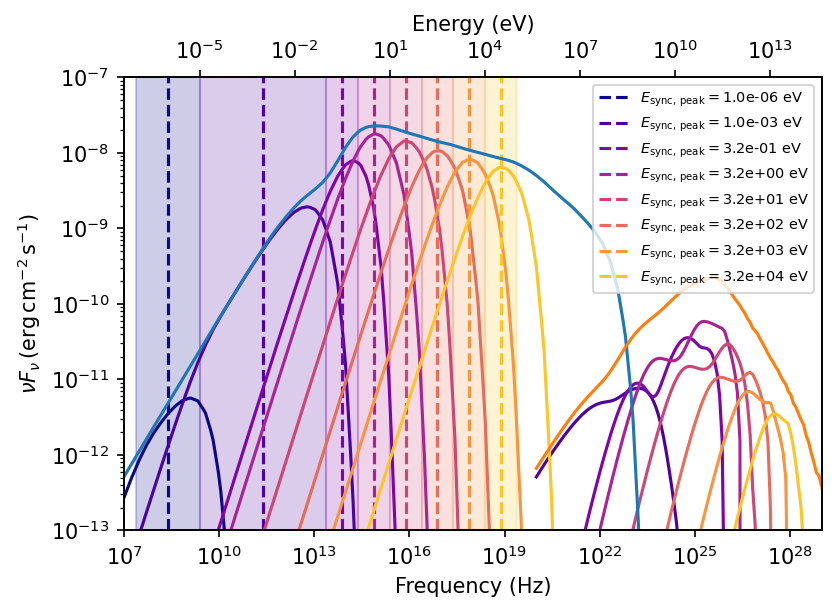

In [135]:
fig = plt.figure(dpi=150)
ax=fig.add_subplot(111)

cp = plt.cm.plasma

for i, f in enumerate(f_nu_sync_bins):
    color = cp(i / float(f_nu_sync_bins.shape[0]))
    
    ax.loglog(nu_sync, f * nu_sync, color=color)

    ax.axvline(Epeak[i].to("J").value / c.h.value, ls='--', color=color,
               label="$E_\mathrm{{sync,\,peak}} = ${0:.1e}".format(Epeak[i]))
    
    v = ax.get_ylim()
    ax.fill_betweenx([1e-13, 1e-7], Epeak_bins[i] * np.ones(2) * u.eV.to("J") / c.h.value,
                     x2=Epeak_bins[i+1] * u.eV.to("J") / c.h.value,
                     color=color, alpha=0.2)
    
    ax.loglog(nu_ic, f_nu_ic_bins[i] * nu_ic, color=color)

plt.legend(fontsize='x-small')
plot_full_sed(luminosity=False, ic=True, dust=False, fig=fig, total=False, ax=ax)

### Plot the predicted extension as function of energy 

In order to this, we have to first make sure what we want to plot. The extension comes from the assumed extension for the electron density. In the const. B-field model, the extension of the electron density is modeled with a Gaussian, $n_e(r, \gamma) \propto \exp(-r^2 / (2\sigma(\gamma))$, where the extension $\sigma$ depends on the electron energy $\gamma$. However, what we observe is the extension in photon energies. 

What we have readily available from the code is the intensity as a function of angular separation and photon energy:

Text(0, 0.5, '$I_\\nu / I_\\nu(\\theta = 0^\\circ)$')

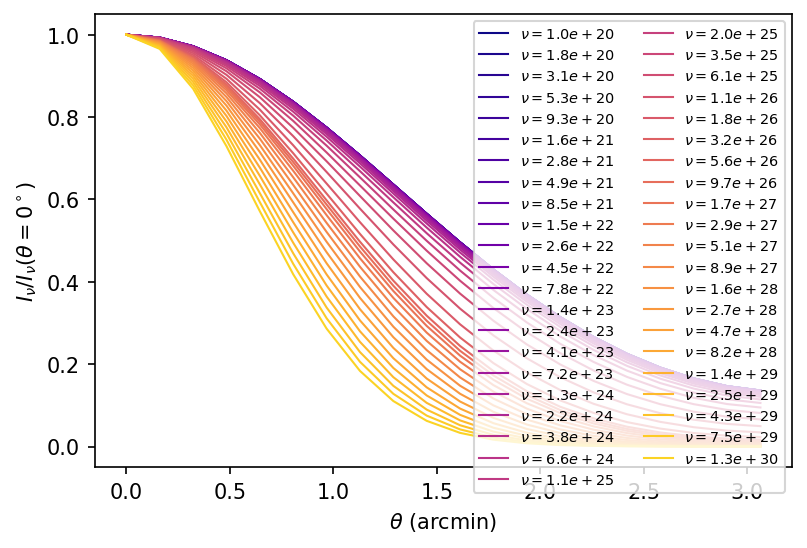

In [136]:
# intensity form factor for different frequencies

plt.figure(dpi=150)
for i, n in enumerate(nu_ic[:-10]):
    if i % 3:
        continue
        
    plt.plot(theta_arcmin_ic, I_nu_sync[i, :] / I_nu_sync[i, 0],
               color=plt.cm.plasma(i / float(nu_ic.size)),
               label=r"$\nu={0:.1e}$".format(n),
               lw=1
            )
    
plt.legend(ncol=2, fontsize='x-small')
plt.xlabel(r"$\theta$ (arcmin)")
plt.ylabel(r"$I_\nu / I_\nu(\theta = 0^\circ)$")

From this, we can derive the flux as an integral over $\theta$ subtained over some interval $\Delta\theta$. This we can use to find the value of $\theta$ where $q = 68\%$ of the emissino is contained. We call this the model extension. 

In [137]:
# first we calculate the flux over an ever larger range of theta
# in order to get the CDF

cdf_ic = np.zeros((theta_arcmin_ic.size - 1, nu_ic.size))
for i, t in enumerate(theta_arcmin_ic[1:]):
    #print (f_nu_ic_theta.shape, i)
    cdf_ic[i] = ssc.flux(nu_ic, theta_edges=[theta_arcmin_ic[0], t],
                         which='ic',
                         integration_mode='romb',
                         r_steps=65,
                         theta_steps=65)
    
cdf_sync = np.zeros((theta_arcmin.size - 1, nu_sync.size))
for i, t in enumerate(theta_arcmin[1:]):
    #print (f_nu_ic_theta.shape, i)
    cdf_sync[i] = ssc.flux(nu_sync, theta_edges=[theta_arcmin[0], t],
                           which='sync',
                           integration_mode='romb',
                           theta_steps=33)
    
cdf_sync = cdf_sync.T
cdf_ic = cdf_ic.T

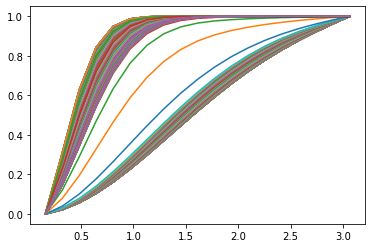

In [141]:
# now we loop through the frequencies and for each frequency 
# determine the radius where 68% of the emission is contained
from scipy.interpolate import UnivariateSpline as USpline

q = 0.68

# loop through frequencies
roots_ic = np.zeros(cdf_ic.shape[0])
for i, _ in enumerate(cdf_ic):
    # normalize CDF and subtract q
    cdf_q = (cdf_ic[i] - cdf_ic[i,0]) / (cdf_ic[i,-1] - cdf_ic[i,0]) - q
    # interpolate
    intp_inv = USpline(theta_arcmin_ic[1:], cdf_q, k=3, s=0)
    #plt.plot(theta_arcmin_ic[1:], cdf_q + q)
    # find the root, i.e. size that corresponds to 0.68 quantile
    roots_ic[i] = intp_inv.roots()[0]
    
roots_sync = np.zeros(cdf_sync.shape[0])
for i, _ in enumerate(cdf_sync):
    # normalize CDF and subtract q
    cdf_q = (cdf_sync[i] - cdf_sync[i,0]) / (cdf_sync[i,-1] - cdf_sync[i,0]) - q
    # interpolate
    intp_inv = USpline(theta_arcmin[1:], cdf_q, k=3, s=0)
    plt.plot(theta_arcmin[1:], cdf_q + q)
    # find the root, i.e. size that corresponds to 0.68 quantile
    roots_sync[i] = intp_inv.roots()[0]

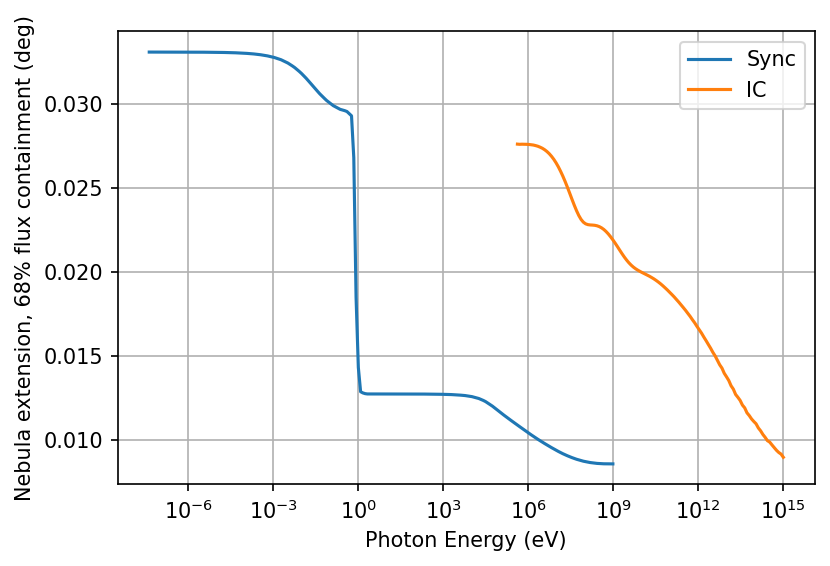

In [144]:
plt.figure(dpi=150)
sl = slice(None, -20, None)
plt.semilogx(nu_sync[sl] * c.h.to("eV s"), np.rad2deg(roots_sync[sl] * arcmin2rad), label="Sync")
plt.semilogx(nu_ic[sl] * c.h.to("eV s"), np.rad2deg(roots_ic[sl] * arcmin2rad), label="IC")
plt.xlabel("Photon Energy (eV)")
plt.ylabel("Nebula extension, 68% flux containment (deg)")
plt.grid()
plt.legend()